### Testing approach with SAM + Florence + Dino

In [1]:
import sys, os
from pathlib import Path
from tqdm.auto import tqdm

# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import (
    AutoProcessor,
    AutoModelForCausalLM,
    AutoImageProcessor,
    AutoModel
)

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.float16).__enter__()

/home/denis_fatykhov/Projects/vizEnc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cuda


In [2]:
np.random.seed(0xDEADBEEF)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

Service functions to handle proccesing

In [3]:
def get_florence_caption(image_crop, model,
                         processor, device,
                         task="<CAPTION>"):
    """Получить caption от Florence-2"""
    inputs = processor(text=task, images=image_crop, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3,
        use_cache=False
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed = processor.post_process_generation(
        generated_text, task=task,
        image_size=(image_crop.width, image_crop.height)
    )

    return parsed[task]


def get_dinov2_embedding(image_crop, model,
                         processor, device):
    """Получить CLS token от DINOv2"""
    inputs = processor(images=image_crop, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[0, 0].cpu().numpy()


def get_dinov2_embeddings_batch(image_crops, model,
                                processor, device, batch_size=8):
    """Получить эмбеддинги батчами (заготовка для оптимизации)"""
    embeddings = []

    for i in range(0, len(image_crops), batch_size):
        batch = image_crops[i:i + batch_size]
        inputs = processor(images=batch, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # CLS tokens для всего батча
        batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
        embeddings.extend(batch_embeddings)

    return embeddings


def process_masks_with_features(image, masks,
                                florence_model, florence_processor, florence_device,
                                dino_model, dino_processor, dino_device,
                                use_batch=False, batch_size=8):
    """Обработать маски: добавить description и embedding"""

    # Собираем все crops
    crops = []
    for mask_data in masks:
        x, y, w, h = mask_data['bbox']
        crop = image.crop((x, y, x + w, y + h))
        crops.append(crop)

    # Florence captions (пока без батчинга)
    print("Generating captions...")
    for idx, (mask_data, crop) in enumerate(tqdm(zip(masks, crops), total=len(masks))):
        mask_data['description'] = get_florence_caption(
            crop, florence_model, florence_processor, florence_device
        )

    # DINOv2 embeddings (с опциональным батчингом)
    print("Extracting embeddings...")
    if use_batch:
        embeddings = get_dinov2_embeddings_batch(
            crops, dino_model, dino_processor, dino_device, batch_size
        )
        for mask_data, embedding in zip(masks, embeddings):
            mask_data['embedding'] = embedding
    else:
        for mask_data, crop in tqdm(zip(masks, crops), total=len(masks)):
            mask_data['embedding'] = get_dinov2_embedding(
                crop, dino_model, dino_processor, dino_device
            )

    return masks

def visualize_masks_with_descriptions(image, masks, figsize=(25, 20)):
    """Визуализация масок с номерами и списком описаний"""
    fig, (ax_img, ax_text) = plt.subplots(1, 2, figsize=figsize,
                                            gridspec_kw={'width_ratios': [3, 1]})

    # Изображение с масками и номерами
    ax_img.imshow(image)
    plt.sca(ax_img)
    show_anns(masks)

    # Добавляем номера в центре каждой маски
    for idx, mask_data in enumerate(masks):
        x, y, w, h = mask_data['bbox']
        center_x = x + w / 2
        center_y = y + h / 2

        ax_img.text(center_x, center_y, str(idx),
                    color='white', fontsize=14, weight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.6))

    ax_img.axis('off')

    # Список описаний
    ax_text.axis('off')
    descriptions = "\n\n".join([f"{i}: {mask['description']}" for i, mask in enumerate(masks)])
    ax_text.text(0.05, 0.50, descriptions,
                fontsize=11, va='center', ha='left',
                family='monospace', wrap=True)

    plt.tight_layout()
    plt.show()

### Taking Image

In [ ]:
projectDir = Path.cwd().parent
dataDir = projectDir / "data/scand_spot_fountain-lib/output_frames"
sys.path.insert(0, str(projectDir / "sam2"))

In [ ]:
image_raw = Image.open(dataDir / 'frame_000000_t0.000.png')
image = np.array(image_raw.convert("RGB"))
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
# plt.show()

## Automatic mask generation

In [ ]:
# from sam2.build_sam import build_sam2
# from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# sam2_checkpoint = str(projectDir / "sam2/checkpoints/sam2.1_hiera_large.pt")
# model_cfg = 'configs/sam2.1/sam2.1_hiera_l.yaml'

# sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(masks[0].keys())

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
# plt.show() 

### Let's move to generating description with Florence

In [ ]:
torch_dtype = torch.float16

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large-ft",
    dtype=torch_dtype,
    trust_remote_code=True,
    attn_implementation="eager"
).to(device)

processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large-ft",
    trust_remote_code=True
)

prompt = "<CAPTION>"
inputs = processor(text=prompt, images=image_raw, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3,
    use_cache=False
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = processor.post_process_generation(
    generated_text,
    task="<CAPTION>",
    image_size=(image_raw.width, image_raw.height)
)

print(parsed_answer)

In [ ]:
for mask_data in masks:
    # bbox в формате XYWH
    x, y, w, h = mask_data['bbox']

    # Конвертируем в формат (x1, y1, x2, y2) для crop
    x1, y1, x2, y2 = x, y, x + w, y + h

    # Crop объекта
    object_crop = image_raw.crop((x1, y1, x2, y2))

    # Florence-2 описание
    prompt = "<CAPTION>"
    inputs = processor(text=prompt, images=object_crop, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3,
        use_cache=False
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed = processor.post_process_generation(
        generated_text,
        task="<CAPTION>",
        image_size=(object_crop.width, object_crop.height)
    )

    # Добавляем description к маске
    mask_data['description'] = parsed['<CAPTION>']

In [ ]:
fig, (ax_img, ax_text) = plt.subplots(1, 2, figsize=(25, 20),
                                        gridspec_kw={'width_ratios': [3, 1]})

# изображение с масками и номерами
ax_img.imshow(image)
plt.sca(ax_img)
show_anns(masks)

# Добавляем номера в центре каждой маски
for idx, mask_data in enumerate(masks):
    x, y, w, h = mask_data['bbox']
    center_x = x + w / 2
    center_y = y + h / 2

    ax_img.text(center_x, center_y, str(idx),
                color='white', fontsize=14, weight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.6))

ax_img.axis('off')

# список описаний
ax_text.axis('off')
descriptions = "\n\n".join([f"{i}: {mask['description']}" for i, mask in enumerate(masks)])
ax_text.text(0.05, 0.50, descriptions,
            fontsize=11, va='center', ha='left',
            family='monospace', wrap=True)

plt.tight_layout()
# plt.show()

### Baseline

In [4]:
projectDir = Path.cwd().parent
dataDir = projectDir / "data/scand_spot_fountain-lib/output_frames"
sys.path.insert(0, str(projectDir / "sam2"))

frames = sorted(dataDir.glob("frame_*.png"))

In [5]:
sys.path.insert(0, str(projectDir / "segment-anything"))
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/mnt/vol0/weights/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=4,
    pred_iou_thresh=0.95,
    )

/home/denis_fatykhov/Projects/vizEnc/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [6]:
torch_dtype = torch.float16

fl_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large-ft",
    dtype=torch_dtype,
    trust_remote_code=True,
    attn_implementation="eager"
).to(device)

fl_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large-ft",
    trust_remote_code=True
)

dino_model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dino_model.eval()
dino_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)


<unknown>:515: SyntaxWarning: invalid escape sequence '\d'


Frame 0: /home/denis_fatykhov/Projects/vizEnc/data/scand_spot_fountain-lib/output_frames/frame_000000_t0.000.png


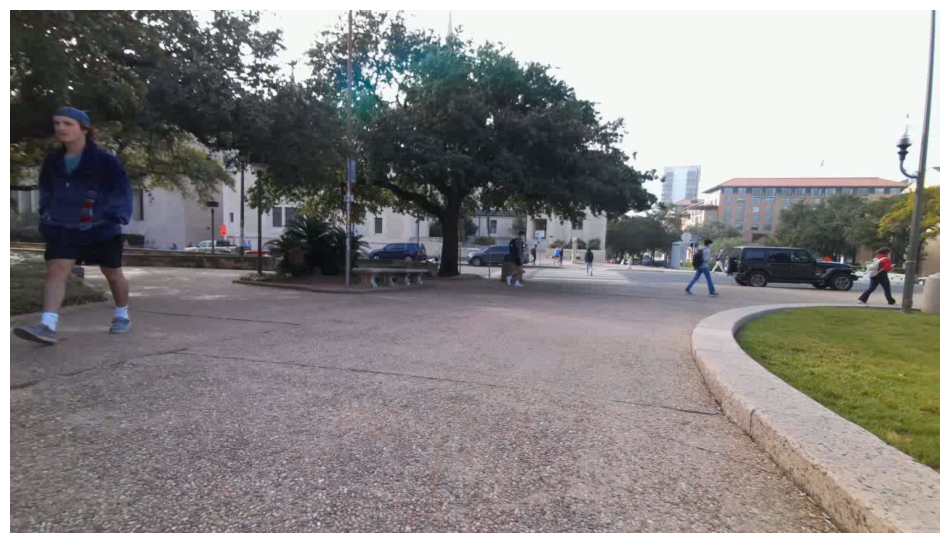

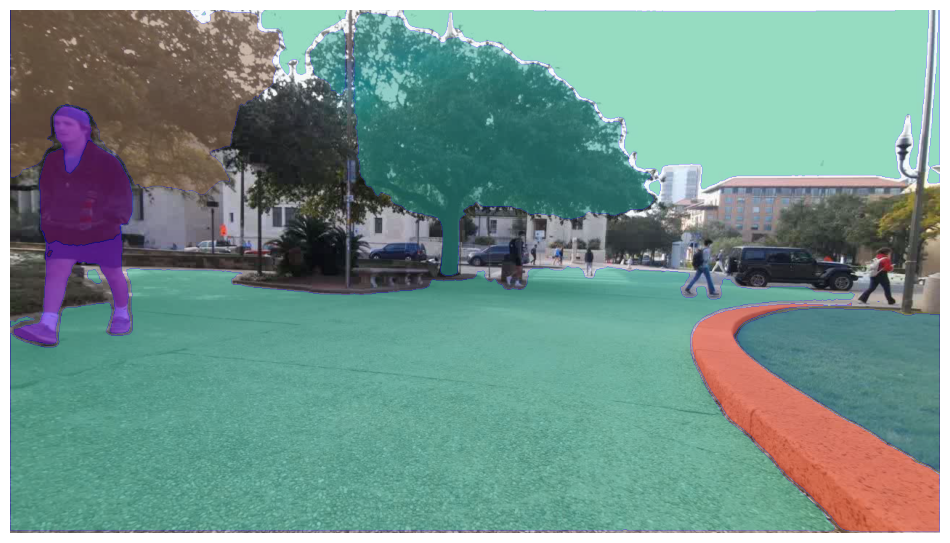

Generating captions...


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Extracting embeddings...


100%|██████████| 8/8 [00:00<00:00, 126.69it/s]


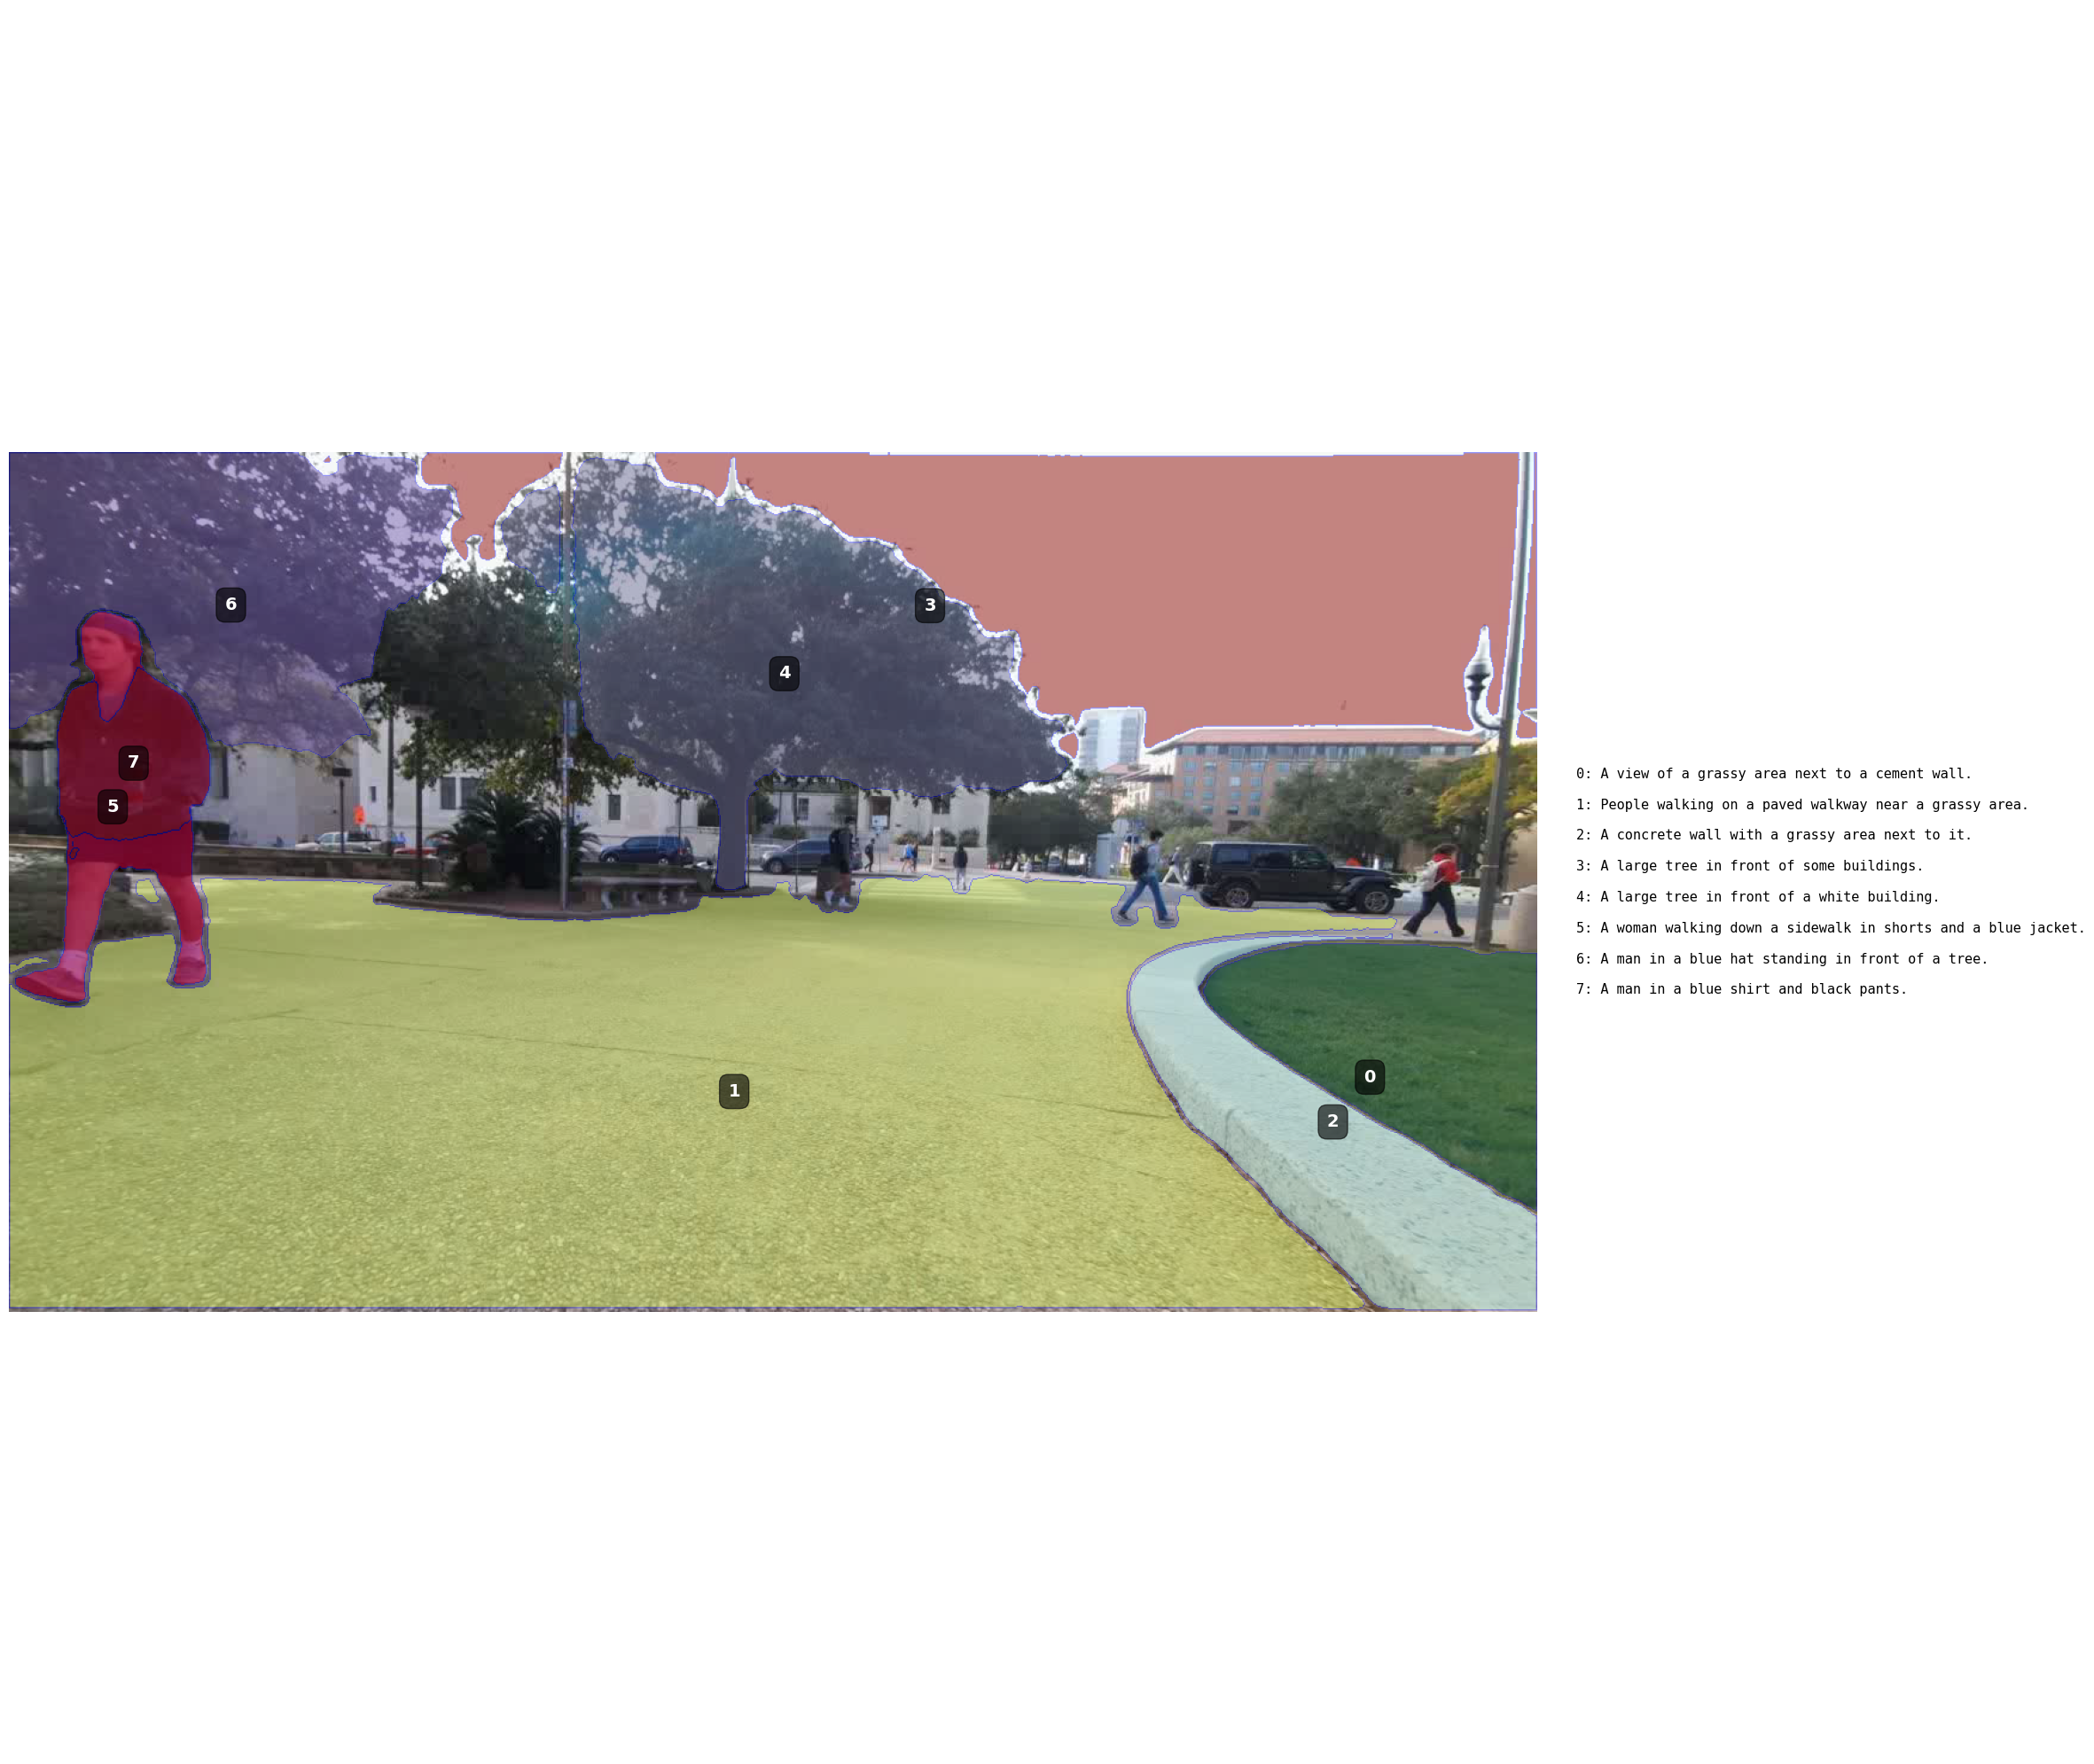

Frame 1: /home/denis_fatykhov/Projects/vizEnc/data/scand_spot_fountain-lib/output_frames/frame_000001_t0.333.png


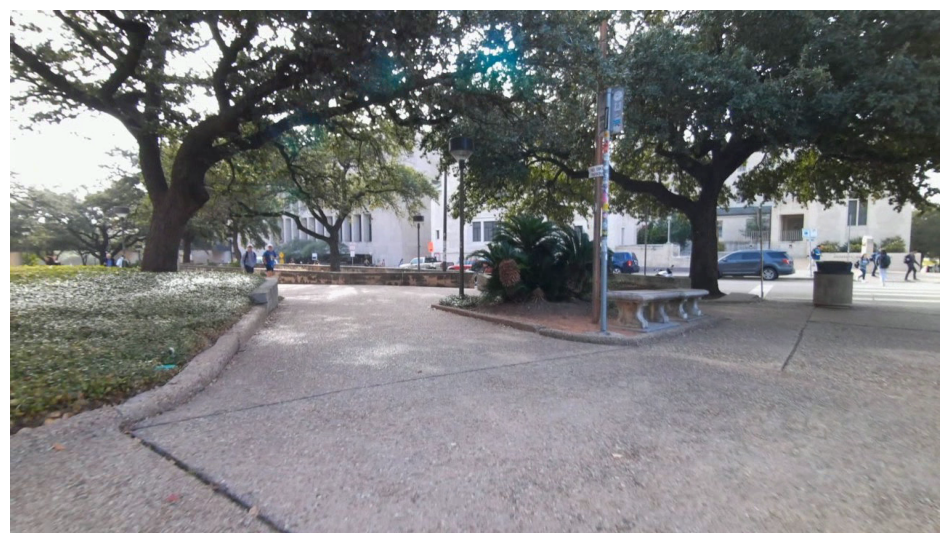

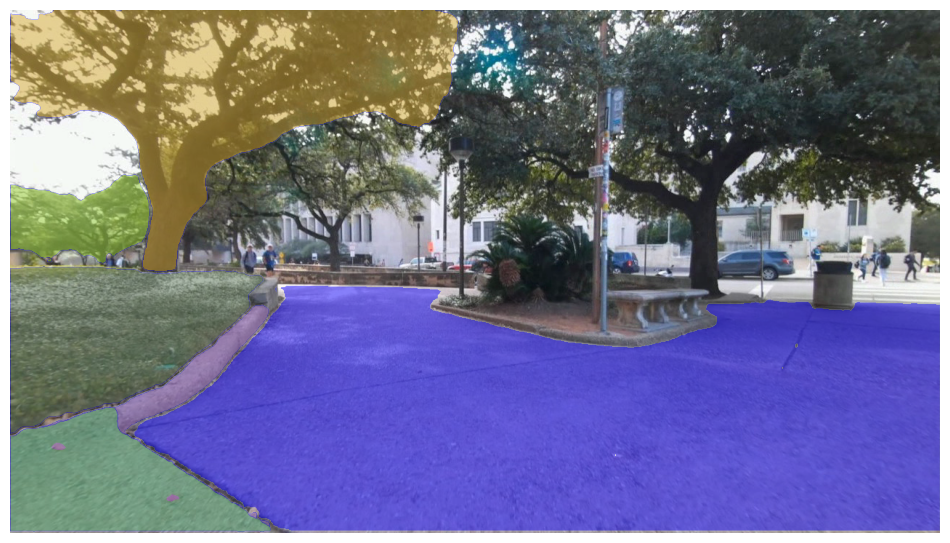

Generating captions...


100%|██████████| 6/6 [00:01<00:00,  4.61it/s]


Extracting embeddings...


100%|██████████| 6/6 [00:00<00:00, 140.73it/s]


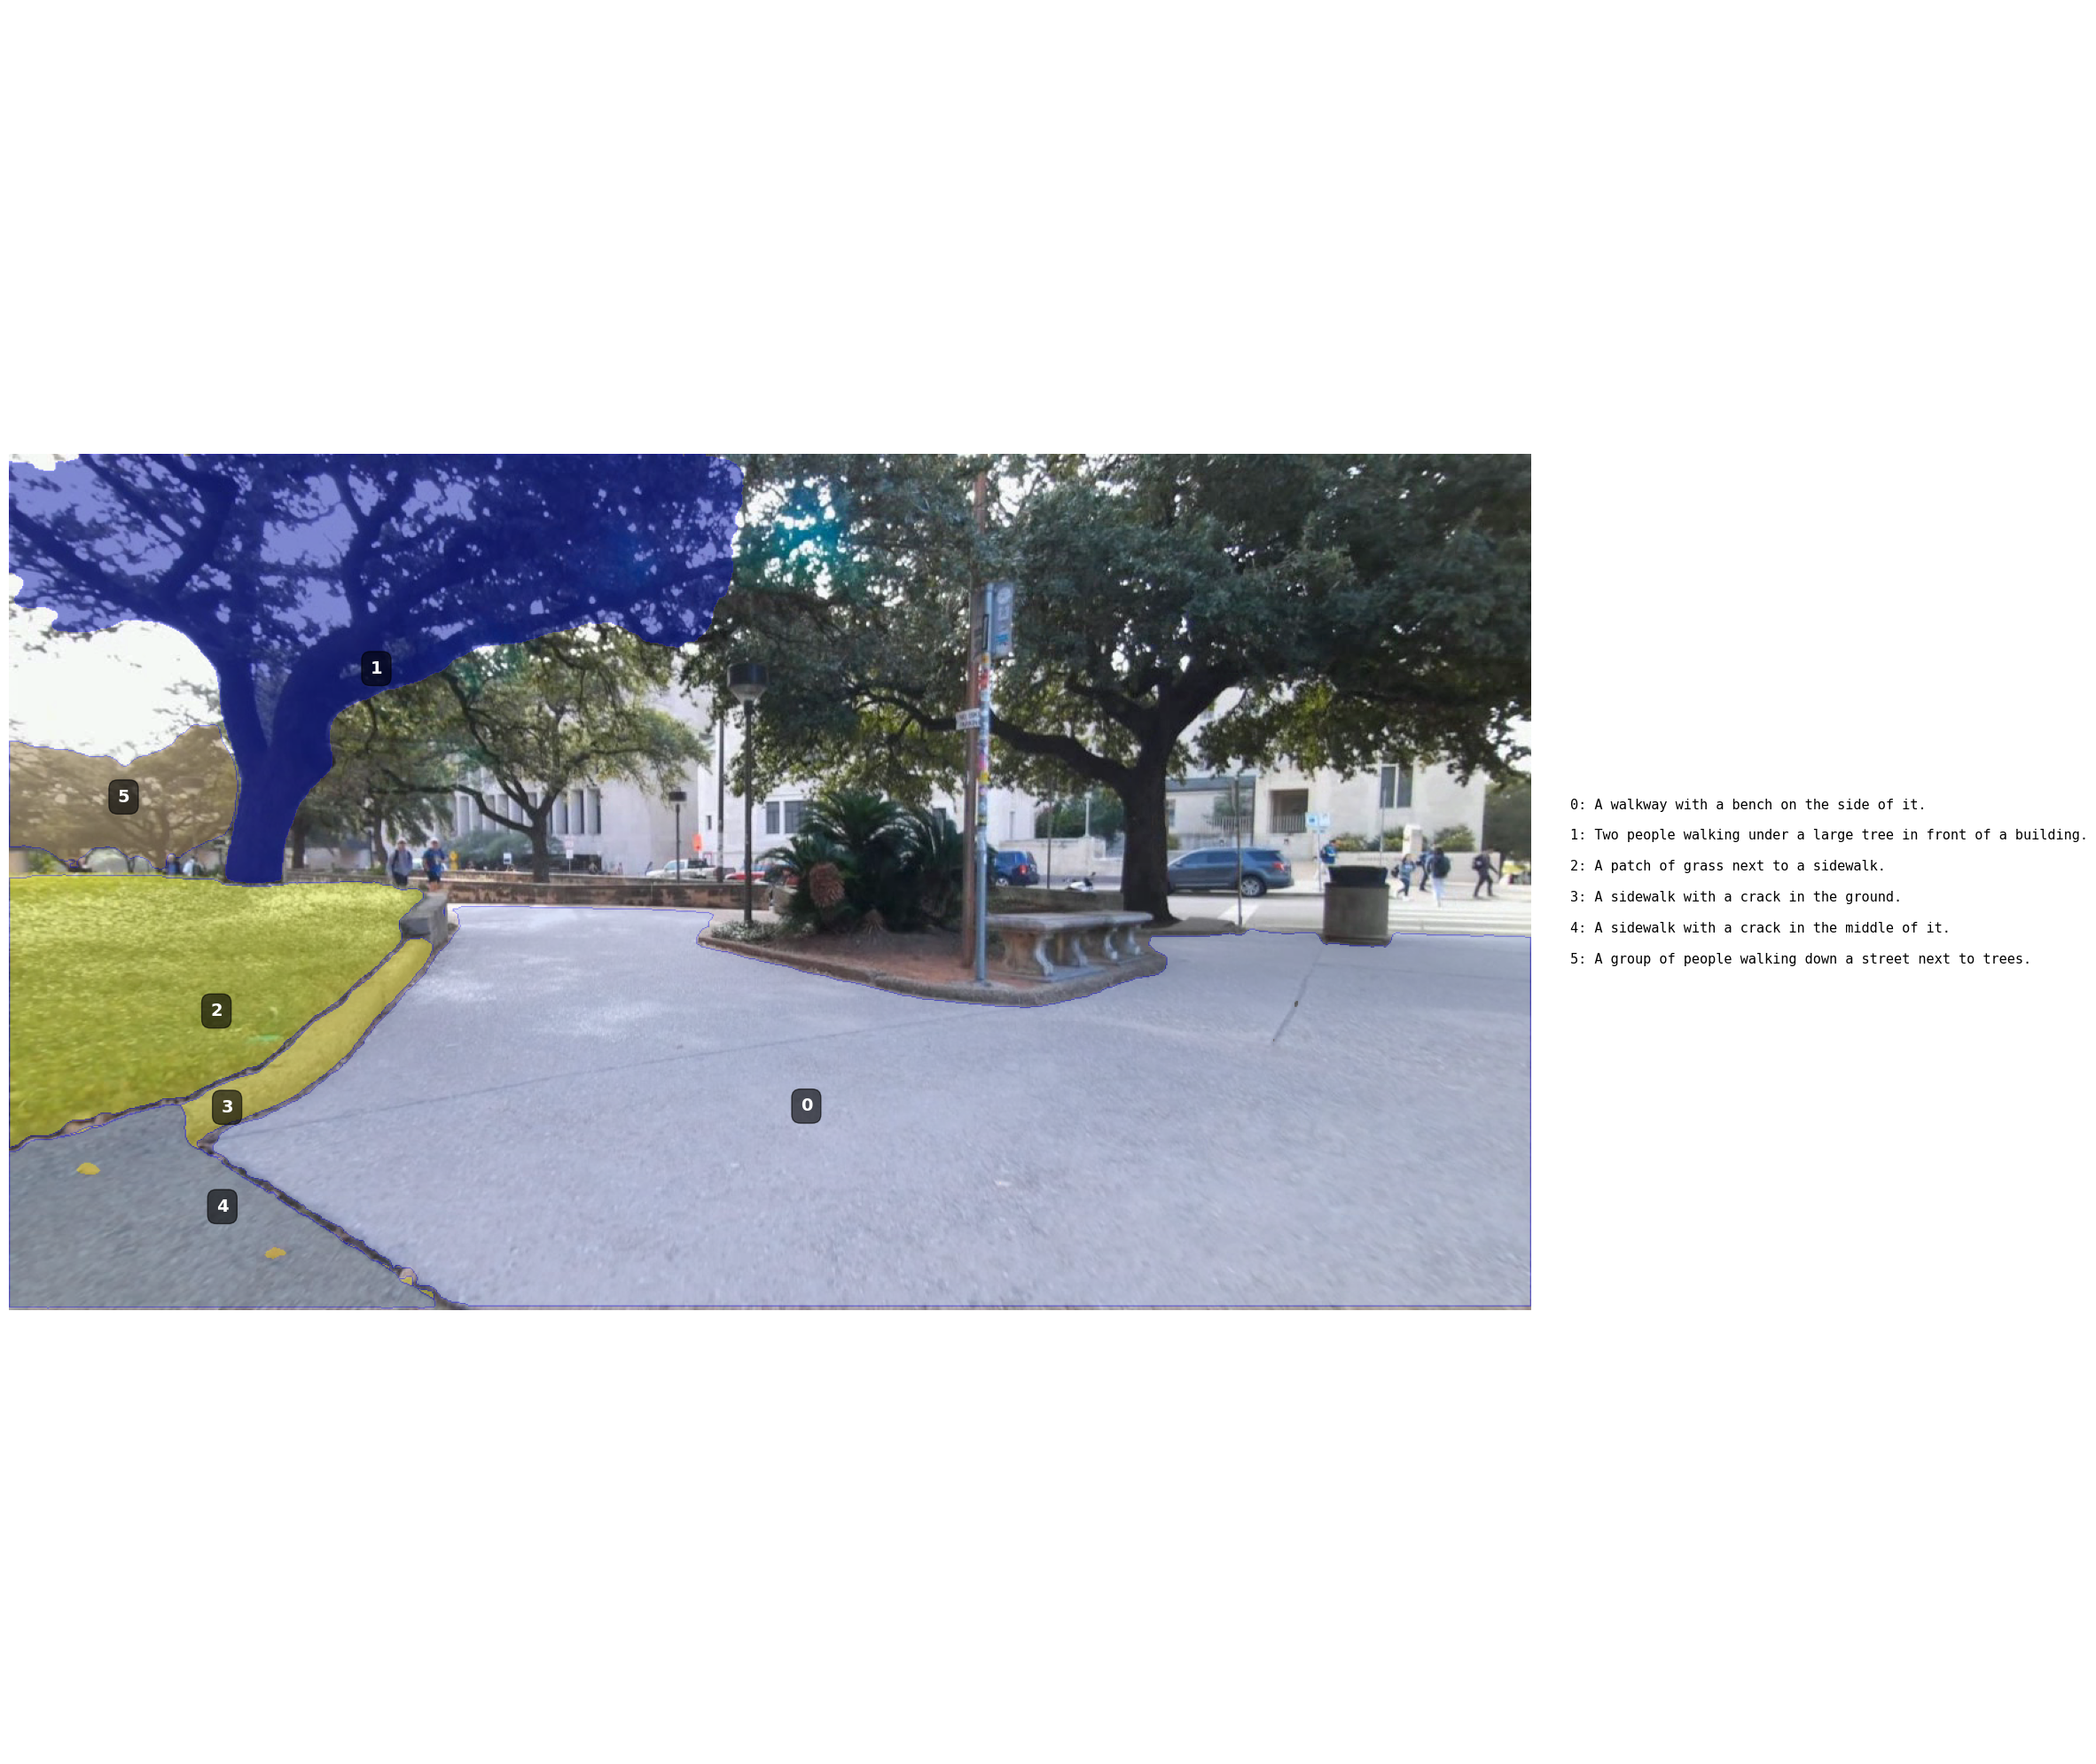

In [7]:
mask_db = []

for index, frame in enumerate(frames):
    print(f"Frame {index}: {frame}")
    image = Image.open(frame).convert("RGB")

    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    masks = mask_generator.generate(np.array(image))

    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')
    plt.show() 

    masks = process_masks_with_features(
        image, masks,
        fl_model, fl_processor, device,
        dino_model, dino_processor, device
    )

    visualize_masks_with_descriptions(image, masks)
    mask_db.append((frame.name, masks))
    
    if index == 1:
        break

In [33]:
type(mask_db[0][1])

list

Frame 0: 8 objects
Frame 1: 6 objects
Total: 14 objects, dim: 768


/home/denis_fatykhov/Projects/vizEnc/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/denis_fatykhov/Projects/vizEnc/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/denis_fatykhov/Projects/vizEnc/.venv/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


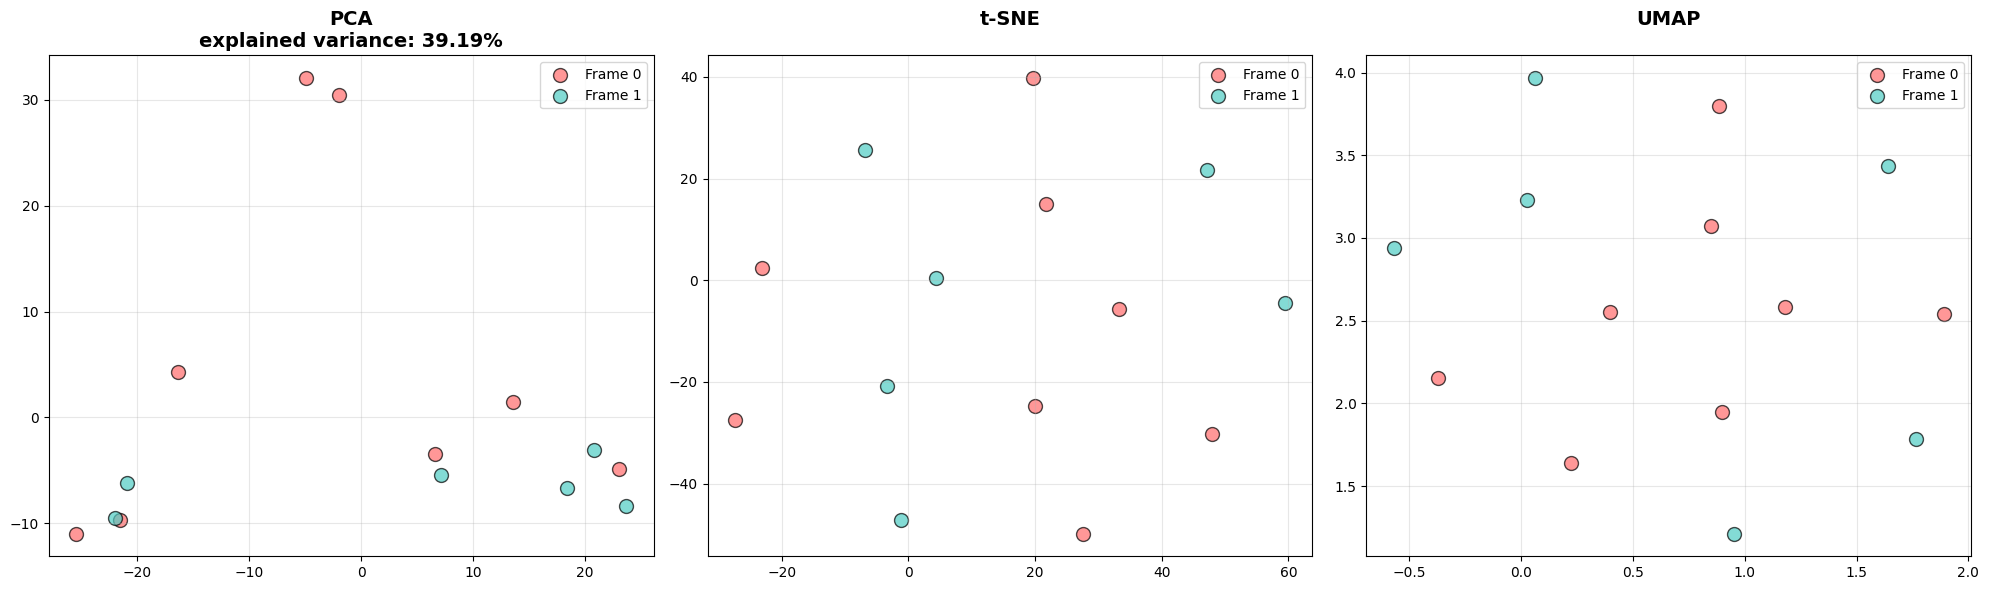

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# 1. Берем только первые 2 кадра
frame0_embeddings = np.array([mask['embedding'] for mask in mask_db[0][1]])
frame1_embeddings = np.array([mask['embedding'] for mask in mask_db[1][1]])

# Объединяем
all_embeddings = np.vstack([frame0_embeddings, frame1_embeddings])

# Метки для цветов (0 = frame 0, 1 = frame 1)
labels = np.array([0] * len(frame0_embeddings) + [1] * len(frame1_embeddings))
colors = ['#FF6B6B', '#4ECDC4']  # красный для frame 0, бирюзовый для frame 1

print(f"Frame 0: {len(frame0_embeddings)} objects")
print(f"Frame 1: {len(frame1_embeddings)} objects")
print(f"Total: {len(all_embeddings)} objects, dim: {all_embeddings.shape[1]}")

# 2. Применяем редукцию размерности
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)-1))
umap = UMAP(n_components=2, random_state=42)

embeddings_pca = pca.fit_transform(all_embeddings)
embeddings_tsne = tsne.fit_transform(all_embeddings)
embeddings_umap = umap.fit_transform(all_embeddings)

# 3. Визуализация
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

methods = [
    (embeddings_pca, 'PCA', f'explained variance: {pca.explained_variance_ratio_.sum():.2%}'),
    (embeddings_tsne, 't-SNE', ''),
    (embeddings_umap, 'UMAP', '')
]

for ax, (embeddings_2d, title, subtitle) in zip(axes, methods):
    # Frame 0
    ax.scatter(embeddings_2d[labels==0, 0], embeddings_2d[labels==0, 1],
                c=colors[0], label='Frame 0', alpha=0.7, s=100, edgecolors='black')
    # Frame 1
    ax.scatter(embeddings_2d[labels==1, 0], embeddings_2d[labels==1, 1],
                c=colors[1], label='Frame 1', alpha=0.7, s=100, edgecolors='black')

    ax.set_title(f'{title}\n{subtitle}', fontsize=14, weight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительно - аннотировать номера объектов:
# # Добавить номера объектов на график
# for i, (x, y) in enumerate(embeddings_2d):
#     ax.annotate(str(i), (x, y), fontsize=8, ha='center', va='center')